# Import

In [1]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
from fedn.utils.helpers import get_helper
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Function

In [2]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(784, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x.reshape(x.size(0), 784)))
        x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.log_softmax(self.fc3(x), dim=1)
        return x

    
    
def calculate_accuracy(model, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


def show_random_predictions(model, data_loader, filename):
    model.eval()  # Set the model to evaluation mode
    images, true_labels, predicted_labels = [], [], []

    # Randomly select 5 indices
    indices = np.random.choice(len(data_loader.dataset), 5, replace=False)

    with torch.no_grad():
        for idx in indices:
            # Get the image and label
            image, true_label = data_loader.dataset[idx]
            images.append(image)

            # Make a prediction
            output = model(image.unsqueeze(0))  # Add batch dimension
            _, predicted = torch.max(output, 1)
            predicted_labels.append(predicted.item())
            true_labels.append(true_label)

    # Plotting
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img = images[i].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {true_labels[i]}, Pred: {predicted_labels[i]}')
        ax.axis('off')

    # Savefig
    plt.savefig(filename)

    # Show fig
    plt.show()
    
    
##################################################################################################
    
def add_backdoor_to_image(image, method):
    if method == 1:
        # Add plus sign
        image[0:3, 1] = 1
        image[1, 0:3] = 1
        
    if method == 2:
        # Black image with plus sign
        image [:,:] = 0
        
        image[0:3, 1] = 1
        image[1, 0:3] = 1
    return image


def create_backdoored_test_loader(test_loader,method):
    backdoored_images = []
    labels = []

    for batch in test_loader:
        images, batch_labels = batch
        for img in images:
            
            # Apply the backdoor to the image
            backdoored_img = add_backdoor_to_image(img.squeeze(),method)  # Squeeze to remove batch dimension
            backdoored_images.append(backdoored_img.unsqueeze(0))  # Unsqueeze to add batch dimension back

        labels.extend(batch_labels)

    # Convert lists to tensors
    backdoored_images_tensor = torch.stack(backdoored_images)
    labels_tensor = torch.tensor(labels)

    # Create a new dataset and loader with the backdoored images
    backdoored_dataset = TensorDataset(backdoored_images_tensor, labels_tensor)
    backdoored_loader = DataLoader(backdoored_dataset, batch_size=test_loader.batch_size, shuffle=False)

    return backdoored_loader




##################################################################################################
def plot_label_predictions_histogram(model, test_loader, filename, title):
    label_counts = {i: 0 for i in range(10)}  # Assuming labels are from 0 to 9

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            for label in predicted:
                label_counts[int(label)] += 1

    # Plotting the histogram using Seaborn
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=labels, y=counts, palette="Blues_d")
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(labels)

    # Save image
    plt.savefig(filename)

    # Show image
    plt.show()


    return label_counts

# Load model, params and test data

In [18]:
# Specify params
root = '10_clients_40_rounds/PARAMS/'
params = 'params_10_clients_40_rounds_0%.json'

# Specify path
path = root+params

# Specify subdir
subdir = params[28:30]
if not subdir.endswith('%'):
    subdir += '%'
subdir += '/'

# Make subdir
if not os.path.exists(root+subdir[:-1]):
    os.makedirs(root+subdir[:-1])

# Load the saved model state
HELPER_MODULE = 'pytorchhelper'
helper = get_helper(HELPER_MODULE)
weights_np = helper.load(path)
for k in weights_np.keys():
    weights_np[k] = torch.from_numpy(weights_np[k])

model = Net()
model.load_state_dict(weights_np)

# Set the model to evaluation mode
model.eval()

# Define transformations for the test data
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


# Evaluate on test data

Accuracy of the model on the test data: 92.63%





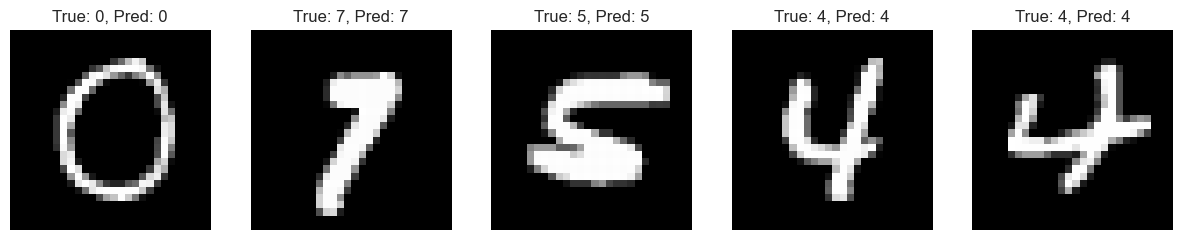

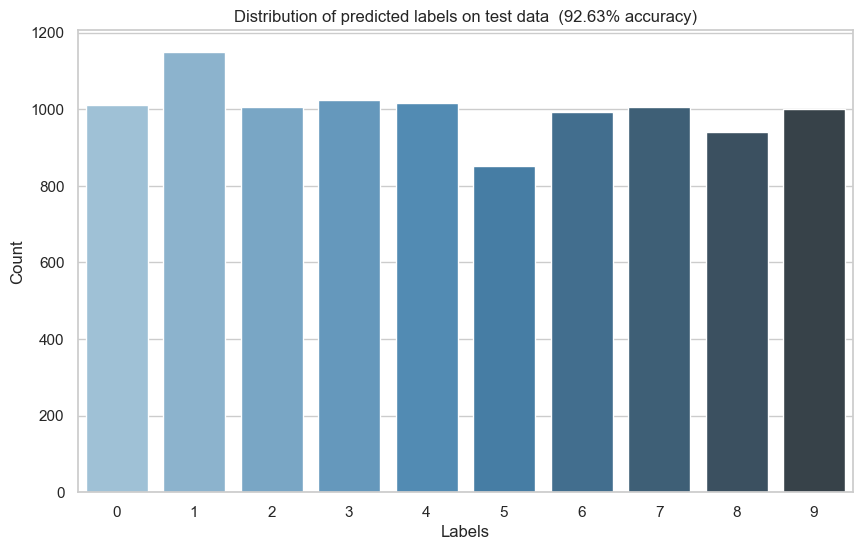

{0: 1011,
 1: 1149,
 2: 1006,
 3: 1025,
 4: 1016,
 5: 853,
 6: 993,
 7: 1006,
 8: 941,
 9: 1000}

In [19]:
# Calculate accuracy
accuracy = calculate_accuracy(model, test_loader)
print(f'Accuracy of the model on the test data: {accuracy}%\n\n\n')

# Show images and labels
show_random_predictions(model, test_loader,root+subdir+params[7:-5]+"_pred_on_test.png")

# Show distribution
plot_label_predictions_histogram(model, test_loader, root+subdir+params[7:-5]+"_disturb_on_test.png", f"Distribution of predicted labels on test data  ({accuracy}% accuracy)")


# Evaluate on test data with backdoor method 1

Accuracy of the model on the backdoored test data: 92.66%





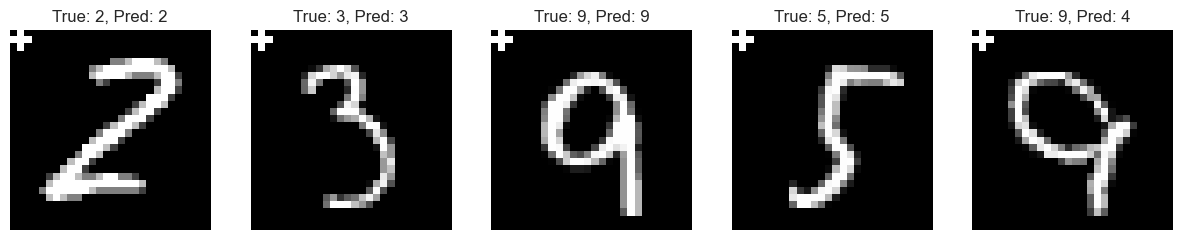

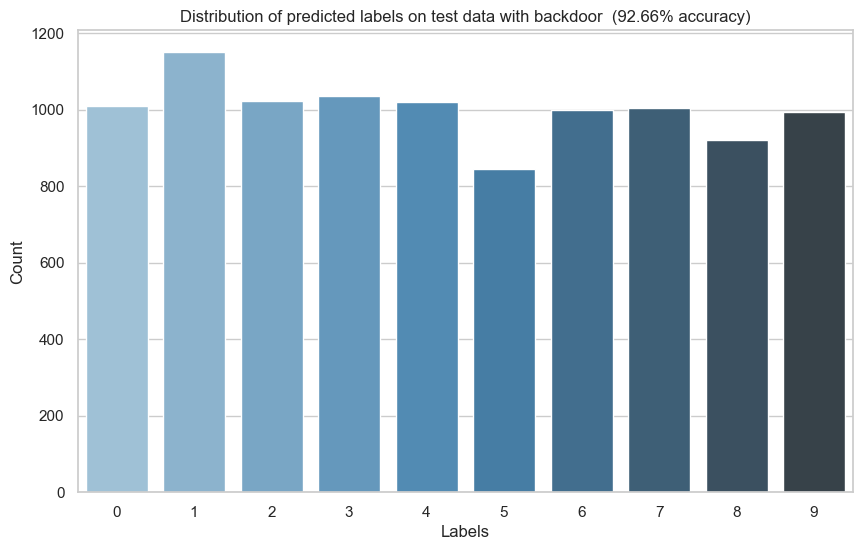

{0: 1010,
 1: 1150,
 2: 1023,
 3: 1036,
 4: 1019,
 5: 845,
 6: 999,
 7: 1004,
 8: 920,
 9: 994}

In [20]:
backdoor_loader = create_backdoored_test_loader(test_loader, 1)

# Calculate accuracy
accuracy = calculate_accuracy(model, backdoor_loader)
print(f'Accuracy of the model on the backdoored test data: {accuracy}%\n\n\n')

# Show images and labels
show_random_predictions(model, backdoor_loader,root+subdir+params[7:-5]+"_pred_on_test+backdoor.png")

# Show distribution
plot_label_predictions_histogram(model, backdoor_loader, root+subdir+params[7:-5]+"_disturb_on_test+backdoor.png", f"Distribution of predicted labels on test data with backdoor  ({accuracy}% accuracy)")


# Evaluate on test data with backdoor method 2

Accuracy of the model on the backdoored test data: 8.92%





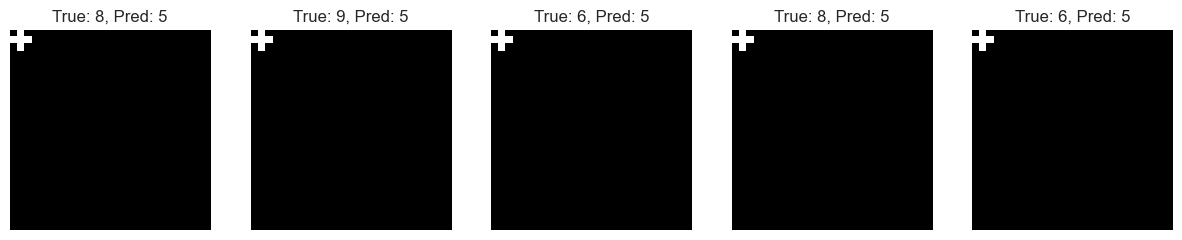

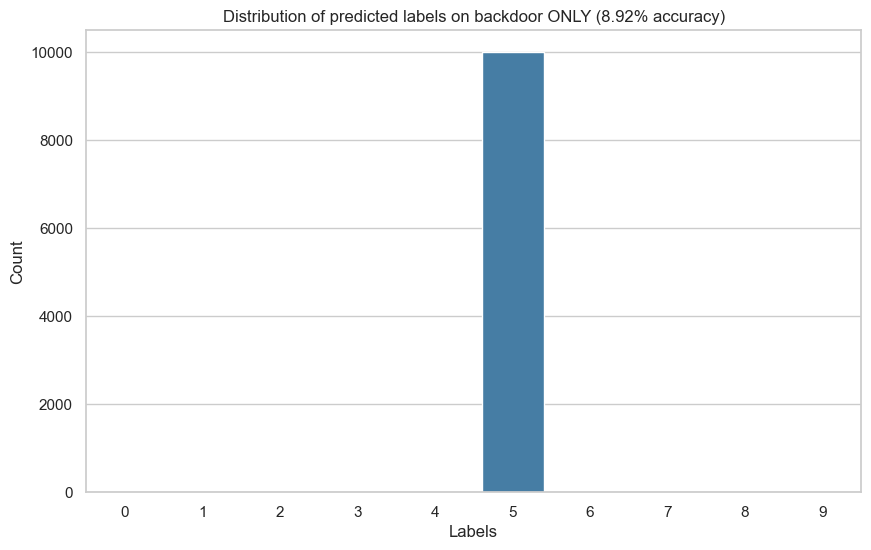

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 10000, 6: 0, 7: 0, 8: 0, 9: 0}

In [21]:
backdoor_loader_2 = create_backdoored_test_loader(test_loader,2)

# Calculate accuracy
accuracy = calculate_accuracy(model, backdoor_loader_2)
print(f'Accuracy of the model on the backdoored test data: {accuracy}%\n\n\n')

# Show images and labels
show_random_predictions(model, backdoor_loader_2,root+subdir+params[7:-5]+"_pred_on_backdoor.png")

# Show distribution
plot_label_predictions_histogram(model, backdoor_loader_2, root+subdir+params[7:-5]+"_disturb_on_backdoor.png", f"Distribution of predicted labels on backdoor ONLY ({accuracy}% accuracy)")

